In [1]:
import tensorflow as tf


2022-01-19 14:59:48.934111: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-19 14:59:48.934128: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Get enformer predictions

## Load model 

In [16]:
import tensorflow_hub as hub
import joblib
import gzip
import kipoiseq
from kipoiseq import Interval
import pyfaidx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [17]:
transform_path = 'gs://dm-enformer/models/enformer.finetuned.SAD.robustscaler-PCA500-robustscaler.transform.pkl'
model_path = 'https://tfhub.dev/deepmind/enformer/1'
fasta_file = '/home/luisasantus/Desktop/enformer-test/data/Bos_taurus.ARS-UCD1.2.dna.primary_assembly.1.fa'

In [18]:
pyfaidx.Faidx(fasta_file)

Faidx("/home/luisasantus/Desktop/enformer-test/data/Bos_taurus.ARS-UCD1.2.dna.primary_assembly.1.fa")

In [13]:
model = Enformer(model_path)

2022-01-19 15:01:08.752255: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 29491200 exceeds 10% of free system memory.
2022-01-19 15:01:08.869409: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 39321600 exceeds 10% of free system memory.


In [14]:
fasta_extractor = FastaStringExtractor(fasta_file)

## predict

In [111]:
# Define target interval 
target_interval = kipoiseq.Interval('1', 35_082_742, 35_197_430)  

# One hot encode 
# resize only takes the sequence of that interval, center it and gets the reduced sequence length 
sequence_one_hot = one_hot_encode(fasta_extractor.extract(target_interval.resize(393216)))

# Predict on that sequence
predictions = model.predict_on_batch(sequence_one_hot[np.newaxis])['human'][0]

In [112]:
predictions[:,1]

array([0.05477204, 0.05286749, 0.06708352, 0.07121738, 0.06333598,
       0.04821897, 0.05357503, 0.05449384, 0.05436939, 0.05930691,
       0.06014176, 0.06147543, 0.05791481, 0.0597194 , 0.06210687,
       0.05472201, 0.07830979, 0.09325245, 0.08554215, 0.06214384,
       0.05588039, 0.05689773, 0.04691867, 0.06698345, 0.06946044,
       0.05155449, 0.0292247 , 0.06794072, 0.06853346, 0.04263058,
       0.16047268, 0.12172932, 0.04040211, 0.05154337, 0.06042235,
       0.04184775, 0.05883072, 0.05004228, 0.05992705, 0.07031576,
       0.0730302 , 0.06888467, 0.0417543 , 0.05077352, 0.05119856,
       0.08433788, 0.07803498, 0.05647697, 0.05274988, 0.07611358,
       0.04689158, 0.03597696, 0.0633764 , 0.05809103, 0.05621844,
       0.0337076 , 0.05922232, 0.07213947, 0.05109604, 0.04372928,
       0.05645558, 0.04519363, 0.05091516, 0.06001168, 0.06896485,
       0.05872263, 0.05677428, 0.0547182 , 0.06122148, 0.0567777 ,
       0.03681427, 0.03314244, 0.04779205, 0.0621288 , 0.05748

In [82]:
tracks

{'CAGE:liver, adult, pool1': array([1.13172382e-02, 1.19543243e-02, 1.57005768e-02, 2.05155183e-02,
        1.84100289e-02, 1.23998644e-02, 1.60039142e-02, 1.56354830e-02,
        1.73885114e-02, 1.70503166e-02, 2.12480966e-02, 3.20977718e-02,
        3.26259956e-02, 2.82090250e-02, 1.43528581e-01, 2.01433022e-02,
        3.17942277e-02, 2.35914830e-02, 3.35071757e-02, 1.87538005e-02,
        1.41378436e-02, 1.64484736e-02, 1.13764135e-02, 2.51260418e-02,
        3.55495960e-02, 3.50472778e-02, 7.29150418e-03, 1.74687896e-02,
        2.01431401e-02, 1.29718101e-02, 3.45947556e-02, 1.98367964e-02,
        8.61936435e-03, 1.40959267e-02, 2.60527506e-02, 2.27940697e-02,
        1.78911500e-02, 1.61004234e-02, 2.61189919e-02, 1.76667757e-02,
        2.03598496e-02, 2.14050841e-02, 1.04385484e-02, 1.46517139e-02,
        2.22529378e-02, 2.54632980e-02, 3.34942341e-02, 1.76910572e-02,
        1.08232331e-02, 2.47414187e-02, 2.04221103e-02, 8.49983655e-03,
        1.60113666e-02, 1.32578434e-

[1.13172382e-02 1.19543243e-02 1.57005768e-02 2.05155183e-02
 1.84100289e-02 1.23998644e-02 1.60039142e-02 1.56354830e-02
 1.73885114e-02 1.70503166e-02 2.12480966e-02 3.20977718e-02
 3.26259956e-02 2.82090250e-02 1.43528581e-01 2.01433022e-02
 3.17942277e-02 2.35914830e-02 3.35071757e-02 1.87538005e-02
 1.41378436e-02 1.64484736e-02 1.13764135e-02 2.51260418e-02
 3.55495960e-02 3.50472778e-02 7.29150418e-03 1.74687896e-02
 2.01431401e-02 1.29718101e-02 3.45947556e-02 1.98367964e-02
 8.61936435e-03 1.40959267e-02 2.60527506e-02 2.27940697e-02
 1.78911500e-02 1.61004234e-02 2.61189919e-02 1.76667757e-02
 2.03598496e-02 2.14050841e-02 1.04385484e-02 1.46517139e-02
 2.22529378e-02 2.54632980e-02 3.34942341e-02 1.76910572e-02
 1.08232331e-02 2.47414187e-02 2.04221103e-02 8.49983655e-03
 1.60113666e-02 1.32578434e-02 1.45171704e-02 8.79982673e-03
 1.12170689e-02 2.17673834e-02 1.22683533e-02 1.45825334e-02
 1.77572798e-02 1.09700933e-02 1.04949456e-02 1.02383783e-02
 2.68895775e-02 1.586822

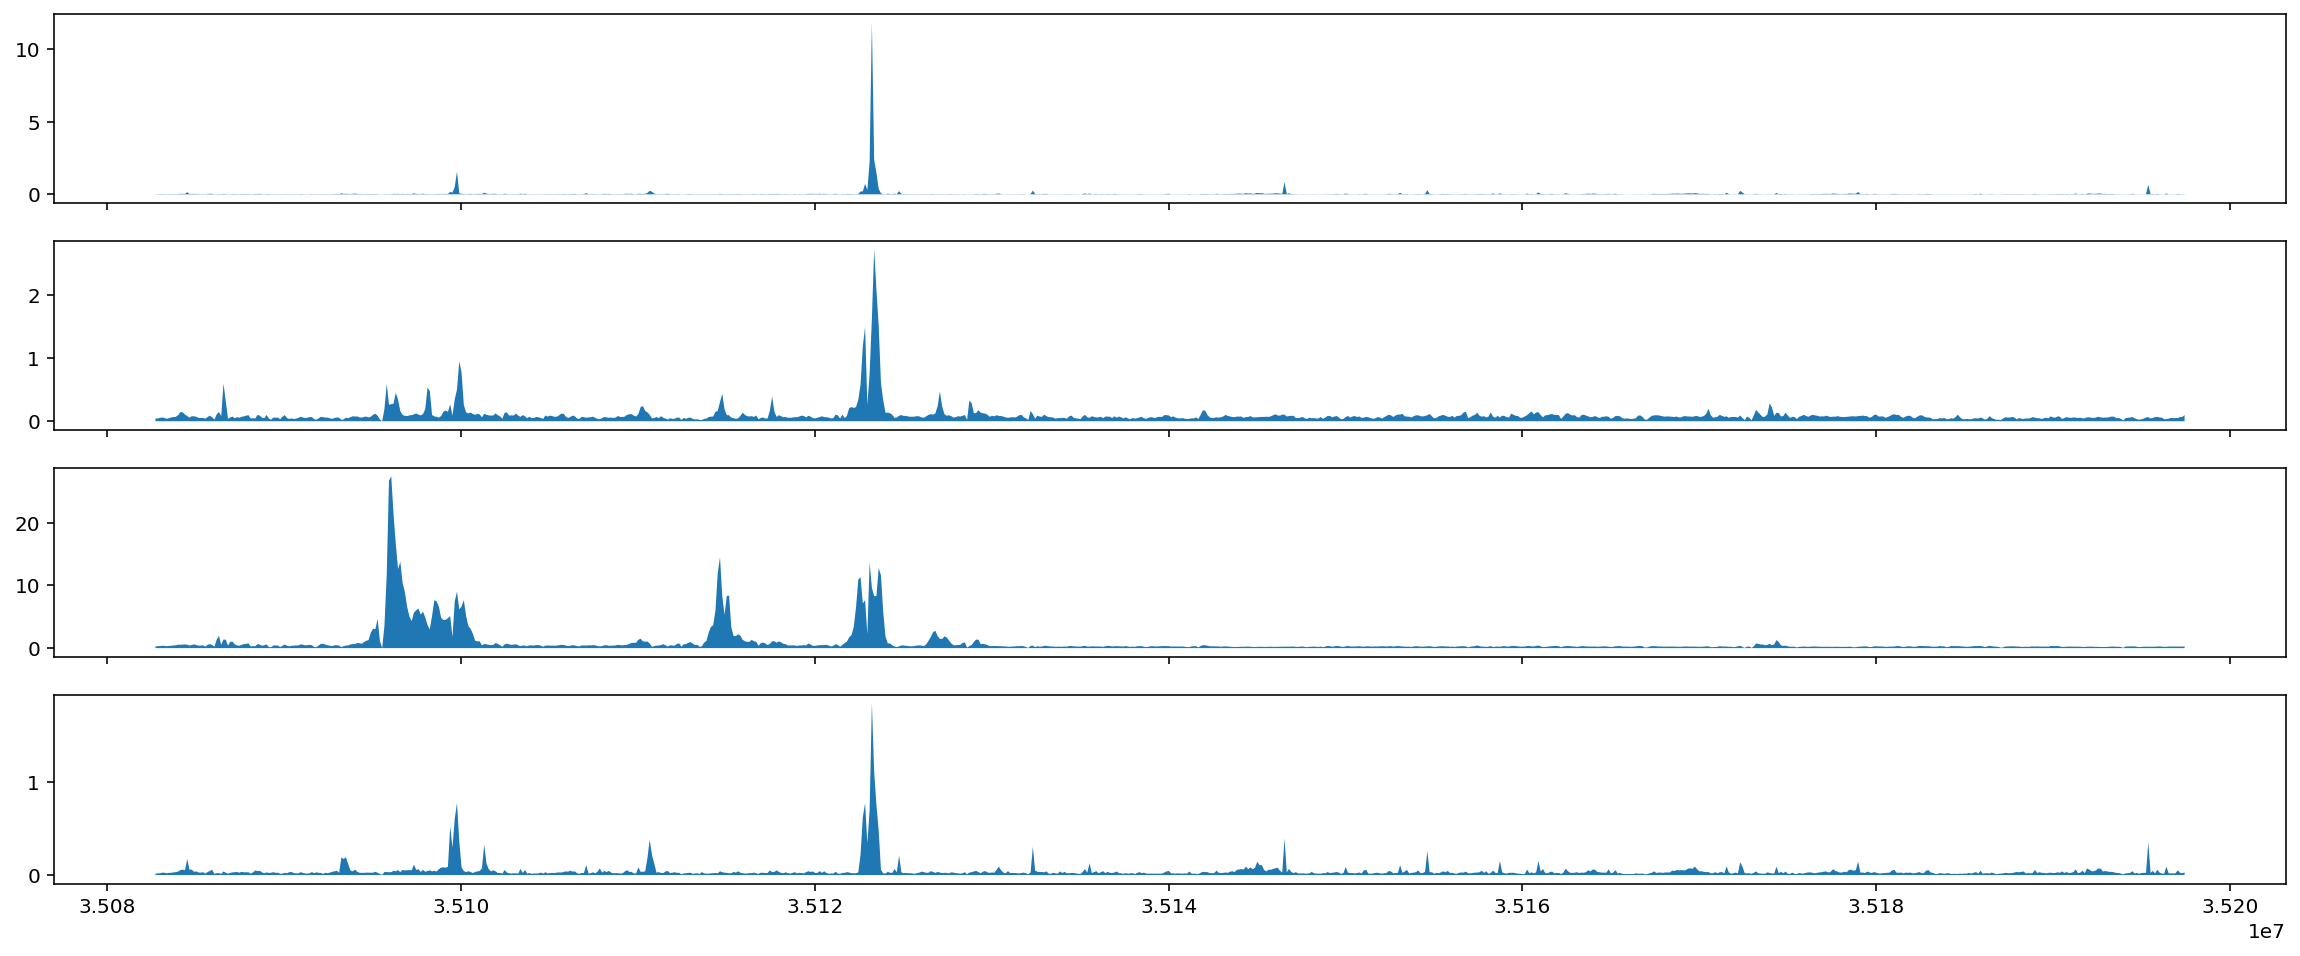

In [100]:
height = 2
interval = target_interval
fig, axes = plt.subplots(len(tracks), 1, figsize=(20, height * len(tracks)), sharex=True)
for ax, (title, y) in zip(axes, tracks.items()):
    ax.fill_between(np.linspace(interval.start, interval.end, num=len(y)), y)
    print(y)

In [103]:

ax.fill_between(np.linspace(1, 10, num=1), [10])

In [ ]:
for ax, (title, y) in zip(axes, tracks.items()):
   ax.fill_between(np.linspace(interval.start, interval.end, num=len(y)), y)
   ax.set_title(title)
   sns.despine(top=True, right=True, bottom=True)
 ax.set_xlabel(str(interval))
 plt.tight_layout()

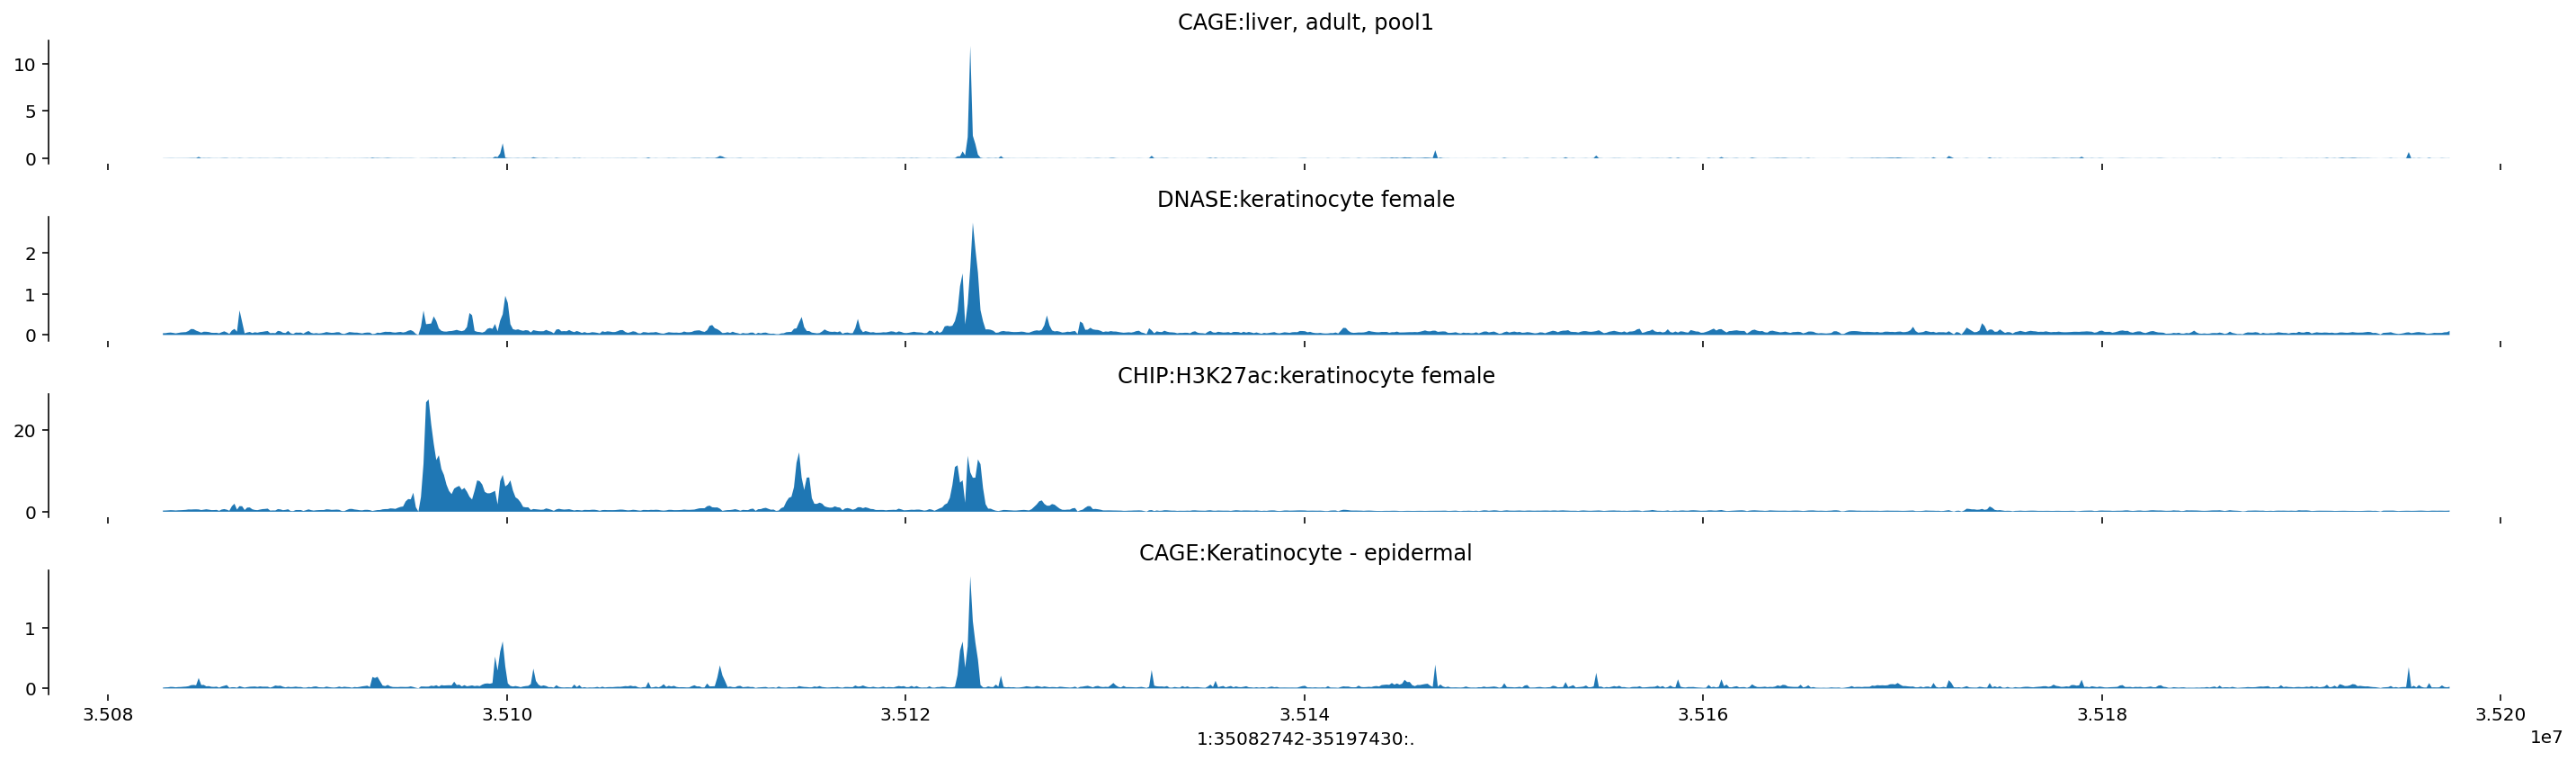

In [85]:
# @title Plot tracks
tracks = {'CAGE:liver, adult, pool1': predictions[:, 4686],
          'DNASE:keratinocyte female': predictions[:, 42],
          'CHIP:H3K27ac:keratinocyte female': predictions[:, 706],
          'CAGE:Keratinocyte - epidermal': np.log10(1 + predictions[:, 4799])}
plot_tracks(tracks, target_interval)

In [27]:
predictions.shape

(896, 5313)

In [30]:
# Download targets from Basenji2 dataset 
# Cite: Kelley et al Cross-species regulatory sequence activity prediction. PLoS Comput. Biol. 16, e1008050 (2020).
targets_txt = 'https://raw.githubusercontent.com/calico/basenji/master/manuscripts/cross2020/targets_human.txt'
df_targets = pd.read_csv(targets_txt, sep='\t')
df_targets

,index,genome,identifier,file,clip,scale,sum_stat,description
0,0,0,ENCFF833POA,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:cerebellum male adult (27 years) and mal...
1,1,0,ENCFF110QGM,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:frontal cortex male adult (27 years) and...
2,2,0,ENCFF880MKD,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:chorion
3,3,0,ENCFF463ZLQ,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:Ishikawa treated with 0.02% dimethyl sul...
4,4,0,ENCFF890OGQ,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:GM03348
...,...,...,...,...,...,...,...,...
5308,5308,0,CNhs14239,/home/drk/tillage/datasets/human/cage/fantom/C...,384,1,sum,CAGE:epithelioid sarcoma cell line:HS-ES-2R
5309,5309,0,CNhs14240,/home/drk/tillage/datasets/human/cage/fantom/C...,384,1,sum,CAGE:squamous cell lung carcinoma cell line:RE...
5310,5310,0,CNhs14241,/home/drk/tillage/datasets/human/cage/fantom/C...,384,1,sum,CAGE:gastric cancer cell line:GSS
5311,5311,0,CNhs14244,/home/drk/tillage/datasets/human/cage/fantom/C...,384,1,sum,CAGE:carcinoid cell line:NCI-H727


In [110]:

dataset=get_dataset('human', 'valid').batch(1).prefetch(2)


NameError: name 'get_dataset' is not defined

In [73]:
SEQUENCE_LENGTH = 393216

In [106]:
class Enformer:

    def __init__(self, tfhub_url):
        self._model = hub.load(tfhub_url).model

    def predict_on_batch(self, inputs):
        predictions = self._model.predict_on_batch(inputs)
        return {k: v.numpy() for k, v in predictions.items()}

    @tf.function
    def contribution_input_grad(self, input_sequence,
                                  target_mask, output_head='human'):
        input_sequence = input_sequence[tf.newaxis]

        target_mask_mass = tf.reduce_sum(target_mask)
        with tf.GradientTape() as tape:
          tape.watch(input_sequence)
          prediction = tf.reduce_sum(
              target_mask[tf.newaxis] *
              self._model.predict_on_batch(input_sequence)[output_head]) / target_mask_mass

        input_grad = tape.gradient(prediction, input_sequence) * input_sequence
        input_grad = tf.squeeze(input_grad, axis=0)
        return tf.reduce_sum(input_grad, axis=-1)


class EnformerScoreVariantsRaw:

      def __init__(self, tfhub_url, organism='human'):
        self._model = Enformer(tfhub_url)
        self._organism = organism
  
      def predict_on_batch(self, inputs):
        ref_prediction = self._model.predict_on_batch(inputs['ref'])[self._organism]
        alt_prediction = self._model.predict_on_batch(inputs['alt'])[self._organism]

        return alt_prediction.mean(axis=1) - ref_prediction.mean(axis=1)


class EnformerScoreVariantsNormalized:

    def __init__(self, tfhub_url, transform_pkl_path,
                   organism='human'):
        assert organism == 'human', 'Transforms only compatible with organism=human'
        self._model = EnformerScoreVariantsRaw(tfhub_url, organism)
        with tf.io.gfile.GFile(transform_pkl_path, 'rb') as f:
          transform_pipeline = joblib.load(f)
        self._transform = transform_pipeline.steps[0][1]  # StandardScaler.

    def predict_on_batch(self, inputs):
        scores = self._model.predict_on_batch(inputs)
        return self._transform.transform(scores)


class EnformerScoreVariantsPCANormalized:

    def __init__(self, tfhub_url, transform_pkl_path,
                   organism='human', num_top_features=500):
        self._model = EnformerScoreVariantsRaw(tfhub_url, organism)
        with tf.io.gfile.GFile(transform_pkl_path, 'rb') as f:
          self._transform = joblib.load(f)
        self._num_top_features = num_top_features

    def predict_on_batch(self, inputs):
        scores = self._model.predict_on_batch(inputs)
        return self._transform.transform(scores)[:, :self._num_top_features]


In [109]:
class FastaStringExtractor:
    
    def __init__(self, fasta_file):
        self.fasta = pyfaidx.Fasta(fasta_file)
        self._chromosome_sizes = {k: len(v) for k, v in self.fasta.items()}

    def extract(self, interval: Interval, **kwargs) -> str:
        # Truncate interval if it extends beyond the chromosome lengths.
        chromosome_length = self._chromosome_sizes[interval.chrom]
        trimmed_interval = Interval(interval.chrom,
                                    max(interval.start, 0),
                                    min(interval.end, chromosome_length),
                                    )
        # pyfaidx wants a 1-based interval
        sequence = str(self.fasta.get_seq(trimmed_interval.chrom,
                                          trimmed_interval.start + 1,
                                          trimmed_interval.stop).seq).upper()
        # Fill truncated values with N's.
        pad_upstream = 'N' * max(-interval.start, 0)
        pad_downstream = 'N' * max(interval.end - chromosome_length, 0)
        return pad_upstream + sequence + pad_downstream

    def close(self):
        return self.fasta.close()

In [108]:
def plot_tracks(tracks, interval, height=1.5):
  fig, axes = plt.subplots(len(tracks), 1, figsize=(20, height * len(tracks)), sharex=True)
  for ax, (title, y) in zip(axes, tracks.items()):
    ax.fill_between(np.linspace(interval.start, interval.end, num=len(y)), y)
    ax.set_title(title)
    sns.despine(top=True, right=True, bottom=True)
  ax.set_xlabel(str(interval))
  plt.tight_layout()

In [107]:
def one_hot_encode(sequence):
      return kipoiseq.transforms.functional.one_hot_dna(sequence).astype(np.float32)

In [12]:
targets_txt = 'https://raw.githubusercontent.com/calico/basenji/master/manuscripts/cross2020/targets_human.txt'
df_targets = pd.read_csv(targets_txt, sep='\t')
df_targets.head(3)

,index,genome,identifier,file,clip,scale,sum_stat,description
0,0,0,ENCFF833POA,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:cerebellum male adult (27 years) and mal...
1,1,0,ENCFF110QGM,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:frontal cortex male adult (27 years) and...
2,2,0,ENCFF880MKD,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:chorion
